# Image generation with VAE

Author: Hugo Wattelar

Generative AIs are taking up a considerable amount of space in the AI news: image generation by DALL-E, music generation by SUNO, text generation by Chat-GPT, and so on.

There are several algorithms for designing generative AI. In this tutorial, we are going to study one of them, a relatively simple one, called VAE: Variational AutoEncoder, and we are going to use it to generate completely artificial images of handwritten numbers, followed by images of clothing.

## 1. Variational AutoEncoders (VAE)

### 1.1 Autoencoders (AE)

Autoencoders are unsupervised deep learning models that compress and then reconstruct an input signal or image. They consist of two parts:

* the __encoder__ takes the input signal and compresses it to reduce it to a high-dimensional representation that concentrates the relevant information. This restricted high-dimensional space is called the __latent space__.
* The __decoder__ reconstructs the input signal as faithfully as possible from the representation in latent space.

In other words, an encoder-decoder is a bottleneck, a funnel, through which we try to pass an input signal or image by compressing it and then reconstructing it.

This compression of the input signal or image can be achieved using fully-connected layers or convolutional layers, for example. In general, the architecture of the decoder is mirrored to that of the encoder. This architecture, as well as the size of the latent space, are therefore parameters to be optimised.

This algorithm is effectively unsupervised: for example, we have an image database that we want to compress and faithfully reconstruct using an autoencoder based on convolutional layers. To train the model, it is presented with each image in the training database as input __and__ as output, and the parameters of this network are optimised using conventional optimisation algorithms (Adam, gradient descent) so that the calculated output corresponds as closely as possible to the desired output, i.e. the input. The difference between the calculated output and the desired output is measured using a cost function, such as the mean square error (MSE).

Once the model has been (correctly) trained, we can theoretically give it an input image, compress it into a few values in latent space (of chosen size, e.g. 10) using the encoder, use/store/share this compressed representation, then reconstruct the original image using the decoder. Practical, isn't it?

Even better: because we're compressing an image or a signal into a restricted space, we only keep the relevant information and delete the irrelevant... Like noise! Autoencoders can therefore also be used as denoisers, enabling a denoised image or signal to be reconstructed from a noisy image or signal.

### 1.2 Variational Autoencoders.

Variational autoencoders are constructed in the same way as conventional autoencoders: an encoder, a latent space and a decoder. It will also be taught to reconstruct input data, such as images. On the other hand, the image or signal will no longer be compressed in a fixed form, but in a _ slightly fuzzy_ form: probabilistic. The aim of the encoder will be to project the input image or signal into a fuzzy region of latent space.

Let's imagine we have a model that has learned to compress and reconstruct images of cats. With a conventional autoencoder, we can only reconstruct the cats we have given it. With a VAE, we can ask it: "Invent me a new cat that looks like the examples you know."

In a VAE, each datum is no longer represented as a fixed vector in latent space, but as a probability distribution (often a Gaussian distribution) whose mean and variance are calculated.

In [ ]:
# pip install torch torchvision

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader
from torch import nn
from scipy.stats import norm

## 2. VAE from the MNIST database

Here we are going to train a VAE with the MNIST database, made up of images of handwritten figures.

### 2.1 Loading the database

We start by loading the database and converting each image into tensor (for PyTorch). Remember to scale the data between 0 and 1. As we are using the MNIST database offered by Torch, this scaling is already done. Next, we display a few copies of the handwritten numbers.

<span style="color: red"> TODO:</span> Load the data into a DataLoader (we'll choose a batch size of 128 and shuffle=True) and display a few examples.

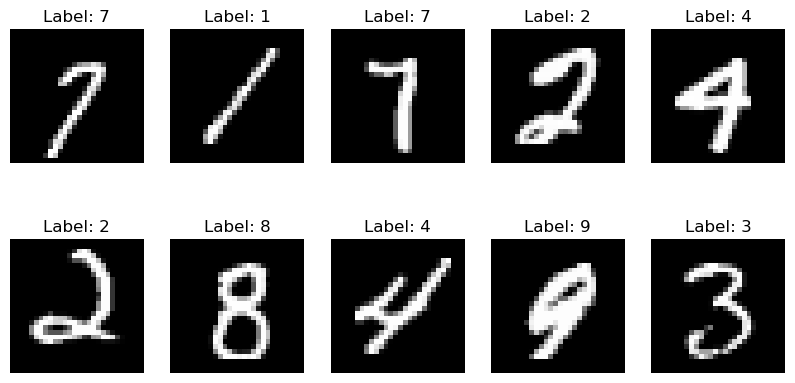

In [ ]:
# Transformations for data
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Loading MNIST data
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_dataset, batch_size=128, shuffle=True) # TODO

# Visualisation of some examples # TODO
examples = iter(mnist_loader)
images, labels = next(examples)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()

### 2.2 VAE building

Below, we propose a VAE architecture based on convolutional layers.

<span style="color: red"> TODO:</span> Given the data format, complete the template below. Also comment on the usefulness of each layer.

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(ConvVAE, self).__init__()

        # Encoder: input image compression
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.BatchNorm2d(32), # Gradient stabilisation and learning acceleration
            nn.ReLU(), # Activation function
            nn.Dropout(0.2), # Regularisation to avoid over-fitting

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.BatchNorm2d(64), # Gradient stabilisation and learning acceleration
            nn.ReLU(), # Activation function
            nn.Dropout(0.2), # Regularisation to avoid over-fitting

            nn.Flatten() # Flatten the image to a column vector
        )

        # Latent space: mean and log variance
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)  # Mean
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)  # Log-variance

        # Decoder: reconstruction of the input image from latent space
        self.fc_dec = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.BatchNorm2d(32), # Gradient stabilisation and learning acceleration
            nn.ReLU(), # Activation function
            nn.Dropout(0.2), # Regularisation to avoid over-fitting

            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),   # 14x14 -> 28x28
            nn.Sigmoid() # Returns values between 0 and 1
        )

    def encode(self, x):
        """Input image compression"""
        h = self.encoder(x)        # Encoding
        mu = self.fc_mu(h) # Calculation of the mean
        logvar = self.fc_logvar(h) # Calculation of log-variance
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparametrisation: we create a variable z that follows a normal distribution (mu, logvar)"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # Add "blur" around the mean to make a Gaussian distribution
        return mu + eps * std

    def decode(self, z):
        """Reconstruction of the input image from the distribution in latent space"""
        h = self.fc_dec(z).view(-1, 64, 7, 7)
        return self.decoder(h)

    def forward(self, x):
        """Use of the entire VAE for training"""
        mu, logvar = self.encode(x)         # Encoding
        z = self.reparameterize(mu, logvar) # Reparameterization
        return self.decode(z), mu, logvar   # Decoding

### 2.3 Training the VAE

To train our model, we first need a way of quantifying the quality of the output. Our cost function must allow us to quantify the quality of the signal reconstruction (reconstruction error to be minimised) as well as the quality of the estimate of the distribution in latent space (Kullback-Leibler divergence, calculation not detailed here). The cost function to be minimised therefore takes the following form:

$$ C(\hat{x}, x, \mu, log\_\sigma^2) = MSE(\hat{x}, x) + KLD(\mu, log\_\sigma^2) $$

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    """Cost function to be minimised in training"""

    # Reconstruction error (MSE)
    mse = nn.functional.mse_loss(recon_x, x, reduction='sum')

    # KL divergence regularisation for the latent term
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # 1 + logvar: encourages σ to remain close to 1, which limits the "size" of the latent distribution
    # -mu: encourages mean to approach 0
    # -exp(logvar): reduces the variance to avoid distributions that are too wide

    return mse + kld

We then need a model to train, an optimizer and a number of epochs.

In [ ]:
cvae_mnist = ConvVAE(latent_dim=2)
optimizer = torch.optim.Adam(cvae_mnist.parameters(), lr=1e-3)
epochs = 20

Finally, we can design the training function of our model.

In [ ]:
def train(model, dataloader, optimizer, loss_function, epochs, pkl_file_name):
    """Fonction d'entraînement"""
    model.train() # Enter training mode (activate certain layers)
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            optimizer.zero_grad() # Reset gradients
            recon_batch, mu, logvar = model(data) # Calculation of the reconstructed image, the mean and the log-variance
            loss = loss_function(recon_batch, data, mu, logvar) # Calculation of the loss
            loss.backward() # Back-propagation of the loss
            train_loss += loss.item()
            optimizer.step() # Updating the optimizer

        print(f"Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset):.4f}")

        with open(pkl_file_name + ".pkl", "wb") as file: # Each time, we save the trained model in case the drive suddenly stops (error, machine shutting down, etc.).
            pickle.dump(model, file)

In [ ]:
# train(cvae_mnist, mnist_loader, optimizer, loss_function, epochs, "cvae_mnist")

## 2.4 Model evaluation

We have a trained model. Alternatively, load a pre-trained model from a pkl file.

In [ ]:
with open("saved_cvae_mnist.pkl", "rb") as file:
    cvae_mnist = pickle.load(file)

In theory, this model has a probabilistic model of each class in its latent space in the form of a Gaussian. To check this, we will evaluate each image in the database and visualise the 2-dimensional representation in latent space on the same graph. The points in each class are coloured differently.

<span style="color: red"> TODO:</span> display the projection of each sample in latent space and assign a colour to each class. What do you notice?

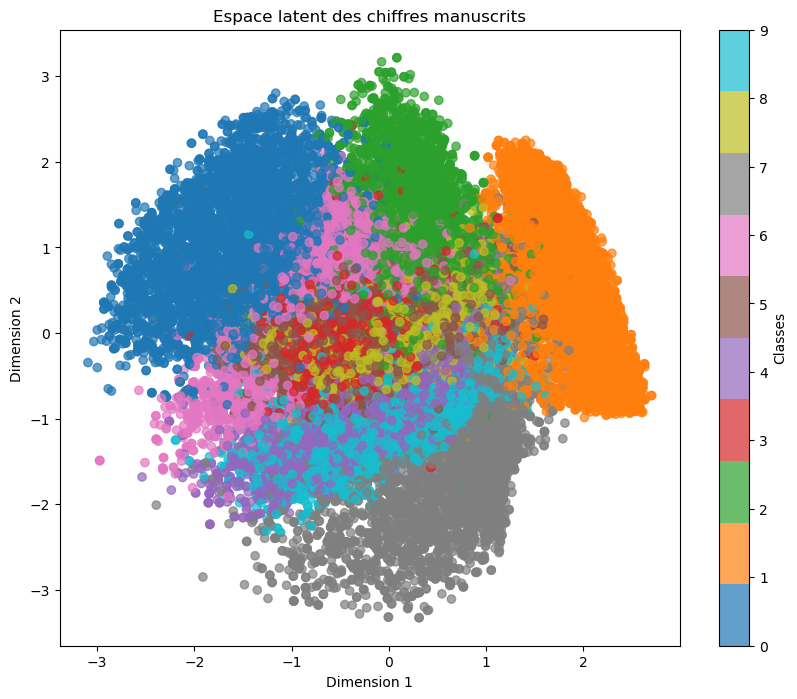

In [ ]:
plt.figure(figsize=(10, 8))

cvae_mnist.eval()
with torch.no_grad():
    for _ in range(len(mnist_loader)):
        data, labels = next(iter(mnist_loader))
        mu, _ = cvae_mnist.encode(data)
        scatter = plt.scatter(mu[:, 0], mu[:, 1], c=labels, cmap='tab10', alpha=0.7)

plt.colorbar(scatter, label="Classes")
plt.title("Espace latent des chiffres manuscrits")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

### 2.5 Generating handwritten digits

Some examples of handwritten ciphers are generated using VAE by decoding randomly generated values passed into latent space.

<span style="color: red"> TODO:</span> Complete the code below so as to generate examples from the proposed latent space.

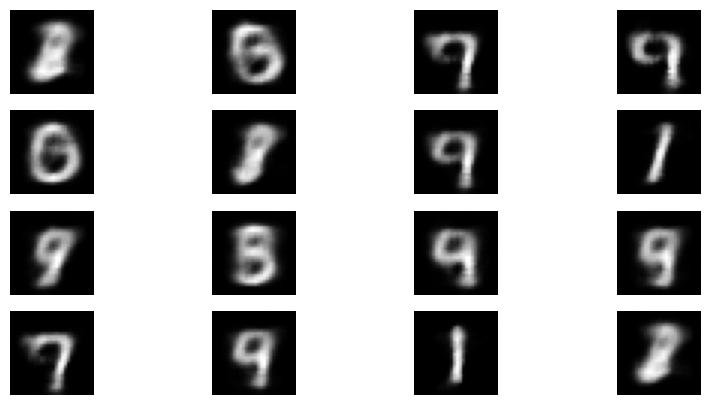

In [ ]:
# Generation of digits from latent space
with torch.no_grad():
    z_samples = torch.randn(16, 2) # Random points in latent space
    generated = cvae_mnist.decode(z_samples).view(-1, 28, 28)

plt.figure(figsize=(10, 5))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated[i], cmap='gray')
    plt.axis('off')
plt.show()

### 2.6 Latent space visualisation

In order to "map" the latent space, a 2D range of data is generated and passed to the VAE decoder.

<span style="color: red"> TODO:</span> Complete the code below and visualise the mapping of the latent space.

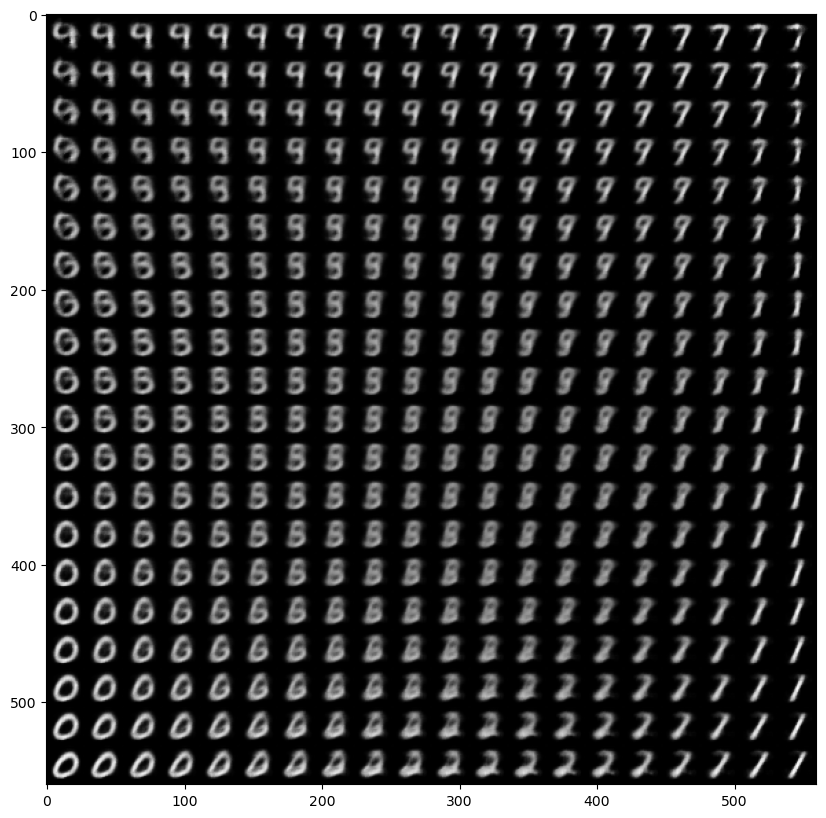

In [ ]:
# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        Z_sample = np.array([[xi, yi]])
        Z_sample = np.tile(Z_sample, 128).reshape(128, 2)
        Z_sample = torch.tensor(Z_sample).to(torch.float32)
        X_decoded = cvae_mnist.decode(Z_sample)
        digit = X_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.detach().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()

## 3. VAE from FashionMNIST data

<span style="color:red"> TODO:</span> Taking inspiration from the previous part, make a clothing image generator using Torch's FashionMNIST database. It is possible to reuse all the elements from the previous part: model, training function, cost function. Carry out the same study as in the previous section.

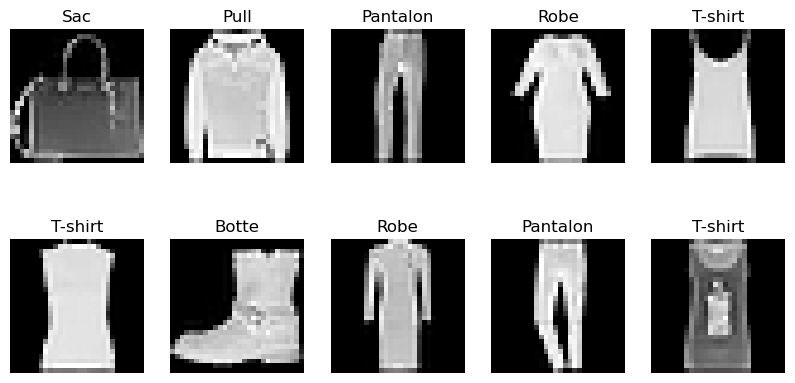

In [ ]:
# Data transformation (standardisation)
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Loading the FashionMNIST dataset
fashion_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_loader = DataLoader(fashion_data, batch_size=128, shuffle=True)

# Data verification
examples = iter(fashion_loader)
images, labels = next(examples)

# List of classes
classes = ['T-shirt', 'Pantalon', 'Pull', 'Robe', 'Manteau',
           'Sandale', 'Chemise', 'Basket', 'Sac', 'Botte']

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

In [ ]:
cvae_fashion = ConvVAE(latent_dim=2)
optimizer = torch.optim.Adam(cvae_fashion.parameters(), lr=1e-3)
epochs = 20

In [ ]:
# train(cvae_fashion, fashion_loader, optimizer, loss_function, epochs, "cvae_fashion_mnist")

In [ ]:
with open("saved_cvae_fashion_mnist.pkl", "rb") as file:
    cvae_fashion = pickle.load(file)

/tmp/ipykernel_5898/4220660411.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  scatter = plt.scatter(mu[np.where(labels==i), 0].numpy(), mu[np.where(labels==i), 1].numpy(), c=colors[i], label=v, alpha=0.7)


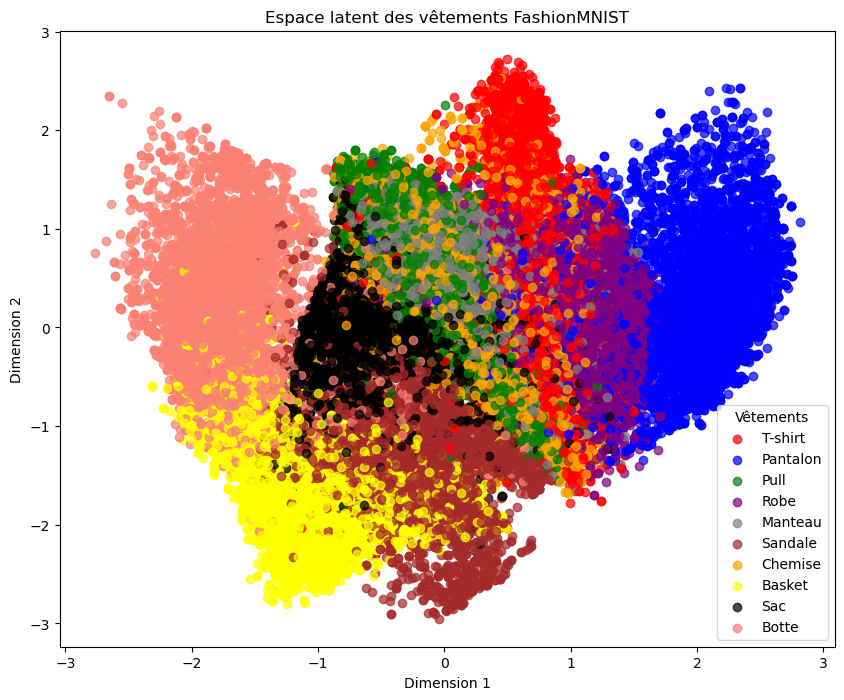

In [ ]:
plt.figure(figsize=(10, 8))

classes = ['T-shirt', 'Pantalon', 'Pull', 'Robe', 'Manteau',
           'Sandale', 'Chemise', 'Basket', 'Sac', 'Botte']
colors = ["red", "blue", "green", "purple", "grey", "brown", "orange", "yellow", "black", "salmon"]

cvae_fashion.eval()
with torch.no_grad():
    for _ in range(len(fashion_loader)):
        data, labels = next(iter(fashion_loader))
        mu, _ = cvae_fashion.encode(data)
        for i,v in enumerate(classes):
            scatter = plt.scatter(mu[np.where(labels==i), 0], mu[np.where(labels==i), 1], c=colors[i], label=v, alpha=0.7)

plt.legend(classes, title="Vêtements")
plt.title("Espace latent des vêtements FashionMNIST")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

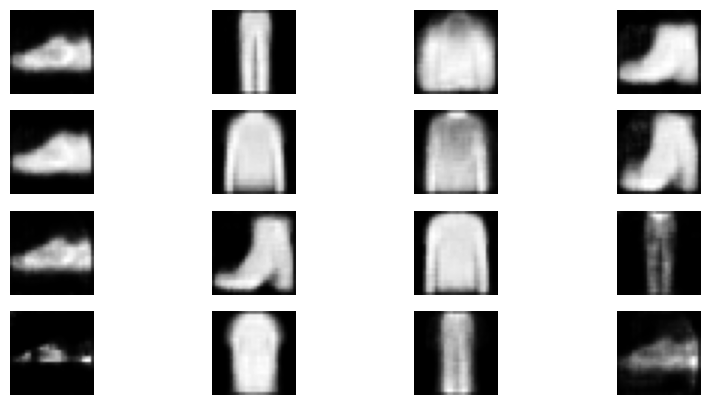

In [ ]:
# Generating images from latent space
with torch.no_grad():
    z_samples = torch.randn(16, 2) # Random points in latent space
    generated = cvae_fashion.decode(z_samples).view(-1, 28, 28)

plt.figure(figsize=(10, 5))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated[i], cmap='gray')
    plt.axis('off')
plt.show()


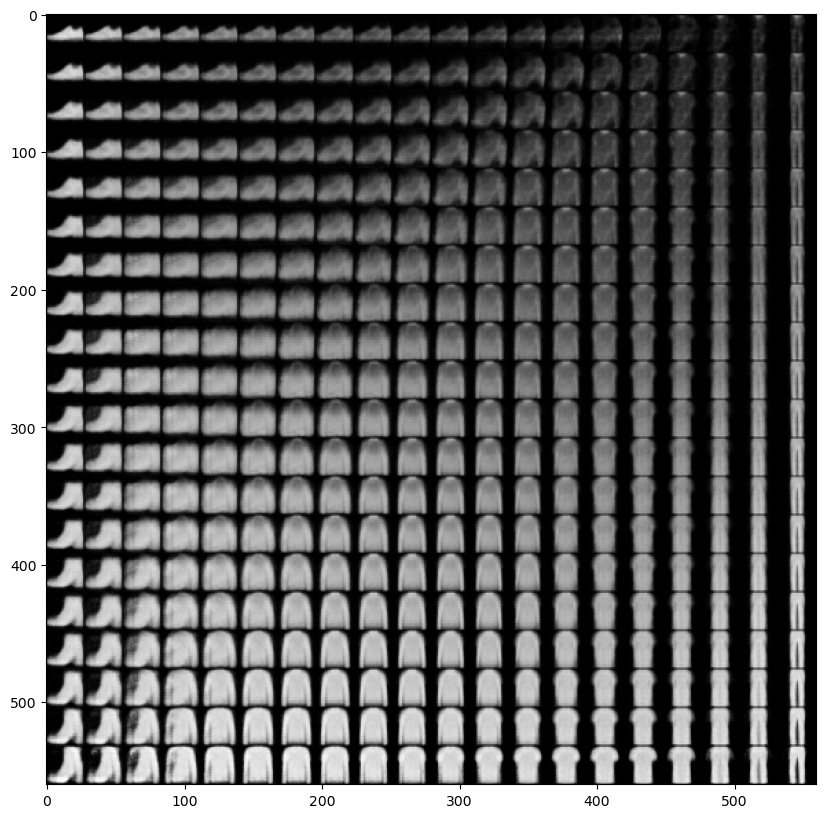

In [ ]:
# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        Z_sample = np.array([[xi, yi]])
        Z_sample = np.tile(Z_sample, 128).reshape(128, 2)
        Z_sample = torch.tensor(Z_sample).to(torch.float32)
        X_decoded = cvae_fashion.decode(Z_sample)
        digit = X_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.detach().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()